In [1]:
from transformers import AutoTokenizer, DataCollatorWithPadding

In [2]:
from datasets import load_dataset

In [3]:
import torch

In [4]:
import numpy as np

In [5]:
from typing import Dict, List

In [6]:
from tqdm.notebook import tqdm

In [7]:
import evaluate

In [8]:
from torch import nn

In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [10]:
from torch.utils.data import DataLoader

In [11]:
mnli = load_dataset(
    "nyu-mll/multi_nli"
).select_columns(
    ["premise", "hypothesis", "label"]
)

In [12]:
mnli["train"]

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 392702
})

In [13]:
mnli["validation_matched"]

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 9815
})

In [14]:
mnli["validation_mismatched"]

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 9832
})

In [15]:
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")

In [16]:
def tokenize(batch: Dict[str, List]):
    return tokenizer(text=batch["premise"], text_pair=batch["hypothesis"], truncation=True, max_length=512)

In [17]:
tokenized_mnli = mnli.map(tokenize, batched=True)

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
accuracy = evaluate.load("accuracy")

In [20]:
def compute_metrics(eval_prediction):
    predictions, labels = eval_prediction
    return accuracy.compute(
        predictions=np.argmax(predictions, axis=1),
        references=labels,
    )

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(
    "google/mobilebert-uncased",
    num_labels=3,
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [23]:
model = model.to("cuda")
model.device

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


device(type='cuda', index=0)

In [24]:
training_args = TrainingArguments(
    output_dir="tmp/mobilebert",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_mnli["train"],
    eval_dataset=tokenized_mnli["validation_matched"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.495200,0.463330,0.814773
2,0.427300,0.442544,0.829343
3,0.368000,0.448722,0.833011
4,0.343800,0.447656,0.834947
5,0.302800,0.464426,0.836984


TrainOutput(global_step=61360, training_loss=1641.5898372418878, metrics={'train_runtime': 12045.4003, 'train_samples_per_second': 163.009, 'train_steps_per_second': 5.094, 'total_flos': 2.2456654476804324e+16, 'train_loss': 1641.5898372418878, 'epoch': 5.0})

In [29]:
torch.save(model.state_dict(), "base-mnli.pt")

In [14]:
def padding_tokenize(batch: Dict[str, List]):
    return tokenizer(
        text=batch["premise"],
        text_pair=batch["hypothesis"],
        truncation=True,
        padding=True,
        # padding="max_length",
        # max_length=512,
        return_tensors="pt",
    )

In [106]:
padded_tokenized_mnli = mnli.map(padding_tokenize, batched=True)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [40]:
def collate_mnli_batch(batch):
    premises = [example["premise"] for example in batch]
    hypotheses = [example["hypothesis"] for example in batch]
    encoding = tokenizer(
        text=premises,
        text_pair=hypotheses,
        truncation=True,
        padding=True,
        # padding="max_length",
        # max_length=512,
        return_tensors="pt",
    )
    
    return {
        "premise": premises,
        "hypothesis": hypotheses,
        "label": torch.LongTensor([example["label"] for example in batch]),
        "input_ids": torch.LongTensor(encoding["input_ids"]),
        "token_type_ids": torch.LongTensor(encoding["token_type_ids"]),
        "attention_mask": torch.LongTensor(encoding["attention_mask"]),
    }

In [41]:
data_loader = DataLoader(
    mnli["validation_matched"],
    batch_size=32,
    collate_fn=collate_mnli_batch,
)

In [17]:
test_model = AutoModelForSequenceClassification.from_pretrained(
    "google/mobilebert-uncased",
    num_labels=3,
    output_attentions=True,
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
test_model = test_model.to("mps")

In [21]:
val_accuracy = evaluate.load("accuracy")

In [22]:
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=batch["input_ids"].to("mps"),
        token_type_ids=batch["token_type_ids"].to("mps"),
        attention_mask=batch["attention_mask"].to("mps"),
    )
    predictions = np.argmax(outputs.logits.softmax(axis=1).detach().cpu().numpy(), axis=1)
    labels = batch["label"].numpy()
    val_accuracy.add_batch(predictions=predictions, references=labels)

  0%|          | 0/307 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [23]:
val_accuracy.compute()

{'accuracy': 0.31818644931227713}

In [24]:
original_attentions = []
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=batch["input_ids"].to("mps"),
        token_type_ids=batch["token_type_ids"].to("mps"),
        attention_mask=batch["attention_mask"].to("mps"),
    )
    original_attentions.append(np.stack([a.detach().cpu().numpy() for a in outputs.attentions]))

  0%|          | 0/307 [00:00<?, ?it/s]

In [25]:
len(original_attentions)

307

In [26]:
test_model.load_state_dict(torch.load("base-mnli.pt"))

/var/folders/lh/54wrb2397y332g93yjhs44v0000cwj/T/ipykernel_42355/2592561591.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("base-m

<All keys matched successfully>

In [27]:
val_accuracy = evaluate.load("accuracy")

In [28]:
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=batch["input_ids"].to("mps"),
        token_type_ids=batch["token_type_ids"].to("mps"),
        attention_mask=batch["attention_mask"].to("mps"),
    )
    predictions = np.argmax(outputs.logits.softmax(axis=1).detach().cpu().numpy(), axis=1)
    labels = batch["label"].numpy()
    val_accuracy.add_batch(predictions=predictions, references=labels)

  0%|          | 0/307 [00:00<?, ?it/s]

In [29]:
val_accuracy.compute()

{'accuracy': 0.8309730005094244}

In [30]:
base_attentions = []
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=batch["input_ids"].to("mps"),
        token_type_ids=batch["token_type_ids"].to("mps"),
        attention_mask=batch["attention_mask"].to("mps"),
    )
    base_attentions.append(np.stack([a.detach().cpu().numpy() for a in outputs.attentions]))

  0%|          | 0/307 [00:00<?, ?it/s]

In [32]:
def prepare_attention_batch(batch):
    return np.transpose(np.reshape(batch, batch.shape[:-2] + (-1,)), axes=(1, 0, 2, 3))

In [34]:
base_attentions[0].shape

(24, 32, 4, 115, 115)

In [35]:
prepare_attention_batch(base_attentions[0]).shape

(32, 24, 4, 13225)

In [34]:
cosine_similarities = []
for batch_pair in tqdm(zip(original_attentions, base_attentions)):
    original_batch, base_batch = batch_pair
    batch_cosine_similarities = nn.functional.cosine_similarity(
        torch.tensor(prepare_attention_batch(original_batch)),
        torch.tensor(prepare_attention_batch(base_batch)),
        dim=-1
    ).detach().cpu().numpy()
    cosine_similarities.append(batch_cosine_similarities)

0it [00:00, ?it/s]

In [35]:
avg_cosine_similarities = np.mean(np.concat(cosine_similarities), axis=0)

In [36]:
avg_cosine_similarities.shape

(24, 4)

In [37]:
avg_cosine_similarities[0]

array([0.99593806, 0.99025327, 0.99138415, 0.99276686], dtype=float32)

In [38]:
import seaborn as sns

<Axes: >

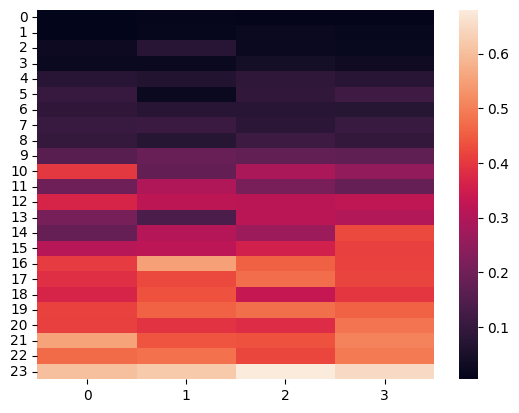

In [39]:
sns.heatmap(1 - avg_cosine_similarities)

In [21]:
model

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [29]:
list(model.mobilebert.encoder.layer[0].attention.self.query.parameters())

[Parameter containing:
 tensor([[-0.2266, -0.0468, -0.1313,  ..., -0.0694,  0.1024,  0.0643],
         [ 0.2212, -0.1479,  0.0529,  ...,  0.1253, -0.0353, -0.0575],
         [ 0.0316, -0.0239,  0.1146,  ..., -0.0174, -0.0099,  0.0407],
         ...,
         [ 0.0746,  0.1113,  0.1695,  ...,  0.1416,  0.0800,  0.0718],
         [-0.1779, -0.0636, -0.2137,  ...,  0.0496, -0.0058,  0.1994],
         [ 0.1006,  0.0032,  0.1494,  ..., -0.0088,  0.1172, -0.1506]],
        device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([ 9.9882e-02, -2.1004e-01, -7.4925e-01, -3.6873e-01,  1.5776e-01,
         -1.2681e-01, -1.4546e-01, -3.0952e-02, -3.1803e-01,  1.3049e-01,
          2.8325e-01,  1.2784e-01,  1.0947e-01,  8.4597e-03,  1.9864e-01,
          1.9554e-01, -1.0397e-01,  8.0338e-02,  2.3664e+00,  4.5677e-02,
         -1.5654e-01, -2.9233e-01, -2.4647e-01, -4.6836e-01, -7.0618e-02,
          1.2230e-02,  2.3433e-01, -1.3977e-03,  8.0074e-02,  2.1029e-01,
          3.6164e-02,  8

In [79]:
sum([param.numel() for param in model.parameters() if param.requires_grad])

24582914

In [19]:
del model

In [21]:
class LoRAUpdate(nn.Module):
    def __init__(self, in_features, out_features, rank, alpha, device=None):
        super().__init__()
        self.A = nn.Parameter(data=torch.empty((in_features, rank), device=device))
        with torch.no_grad():
            nn.init.xavier_normal_(self.A)
        self.B = nn.Parameter(data=torch.zeros((rank, out_features), device=device))
        self.rank = rank
        self.alpha = alpha

    def forward(self, input):
        return (input @ self.A @ self.B) * self.alpha / self.rank

In [22]:
class LoRALayer(nn.Module):
    def __init__(self, original_layer: nn.Linear, rank: int, alpha: int, device=None):
        super().__init__()
        self.original_layer = original_layer
        self.lora_update = LoRAUpdate(
            in_features=original_layer.in_features,
            out_features=original_layer.out_features,
            rank=rank,
            alpha=alpha,
            device=device,
        )

    def forward(self, input):
        return self.original_layer(input) + self.lora_update(input)

In [27]:
lora_model = AutoModelForSequenceClassification.from_pretrained(
    "google/mobilebert-uncased",
    num_labels=3,
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
for param in lora_model.parameters():
    param.requires_grad = False

In [29]:
sum([param.numel() for param in lora_model.parameters() if param.requires_grad])

0

In [30]:
rank = 2
alpha = 2

for layer in lora_model.mobilebert.encoder.layer:
    layer.attention.self.query = LoRALayer(
        layer.attention.self.query,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.self.key = LoRALayer(
        layer.attention.self.key,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.self.value = LoRALayer(
        layer.attention.self.value,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.output.dense = LoRALayer(
        layer.attention.output.dense,
        rank=rank,
        alpha=alpha,
    )

In [31]:
lora_model

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): LoRALayer(
                (original_layer): Linear(in_features=128, out_features=128, bias=True)
                (lora_update): LoRAUpdate()
              )
              (key): LoRALayer(
                (original_layer): Linear(in_features=128, out_features=128, bias=True)
                (lora_update): LoRAUpdate()
              )
              

In [32]:
sum([param.numel() for param in lora_model.parameters() if param.requires_grad])

67584

In [33]:
lora_model = lora_model.to("cuda")
lora_model.device

device(type='cuda', index=0)

In [34]:
lora_training_args = TrainingArguments(
    output_dir="tmp/mobilebert_mnli_lora",
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_mnli["train"],
    eval_dataset=tokenized_mnli["validation_matched"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

lora_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.689400,0.973045,0.778299
2,0.558700,0.740534,0.789710
3,0.529600,0.525349,0.788996
4,0.788000,0.511647,0.797045
5,0.514800,0.505928,0.798879


TrainOutput(global_step=61360, training_loss=6291.218737010881, metrics={'train_runtime': 9506.8474, 'train_samples_per_second': 206.536, 'train_steps_per_second': 6.454, 'total_flos': 2.2531003058577636e+16, 'train_loss': 6291.218737010881, 'epoch': 5.0})

In [35]:
del lora_model

In [23]:
lora_model = AutoModelForSequenceClassification.from_pretrained(
    "google/mobilebert-uncased",
    num_labels=3,
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
for param in lora_model.parameters():
    param.requires_grad = False

In [25]:
sum([param.numel() for param in lora_model.parameters() if param.requires_grad])

0

In [26]:
rank = 8
alpha = 8

for layer in lora_model.mobilebert.encoder.layer:
    layer.attention.self.query = LoRALayer(
        layer.attention.self.query,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.self.key = LoRALayer(
        layer.attention.self.key,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.self.value = LoRALayer(
        layer.attention.self.value,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.output.dense = LoRALayer(
        layer.attention.output.dense,
        rank=rank,
        alpha=alpha,
    )

In [27]:
sum([param.numel() for param in lora_model.parameters() if param.requires_grad])

270336

In [28]:
lora_model = lora_model.to("cuda")
lora_model.device

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


device(type='cuda', index=0)

In [29]:
lora_training_args = TrainingArguments(
    output_dir="tmp/mobilebert_mnli_lora",
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_mnli["train"],
    eval_dataset=tokenized_mnli["validation_matched"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

lora_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.573100,5.807066,0.797759
2,1.449500,0.488299,0.804890
3,0.483200,0.492153,0.807336
4,0.480900,0.467764,0.819358
5,0.602200,0.465857,0.818849


TrainOutput(global_step=61360, training_loss=3056.7252861955485, metrics={'train_runtime': 9181.9545, 'train_samples_per_second': 213.844, 'train_steps_per_second': 6.683, 'total_flos': 2.2754048803897572e+16, 'train_loss': 3056.7252861955485, 'epoch': 5.0})

In [30]:
del lora_model

In [31]:
lora_model = AutoModelForSequenceClassification.from_pretrained(
    "google/mobilebert-uncased",
    num_labels=3,
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
for param in lora_model.parameters():
    param.requires_grad = False

In [33]:
sum([param.numel() for param in lora_model.parameters() if param.requires_grad])

0

In [34]:
rank = 16
alpha = 16

for layer in lora_model.mobilebert.encoder.layer:
    layer.attention.self.query = LoRALayer(
        layer.attention.self.query,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.self.key = LoRALayer(
        layer.attention.self.key,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.self.value = LoRALayer(
        layer.attention.self.value,
        rank=rank,
        alpha=alpha,
    )
    layer.attention.output.dense = LoRALayer(
        layer.attention.output.dense,
        rank=rank,
        alpha=alpha,
    )

In [35]:
sum([param.numel() for param in lora_model.parameters() if param.requires_grad])

540672

In [36]:
lora_model = lora_model.to("cuda")
lora_model.device

device(type='cuda', index=0)

In [37]:
lora_training_args = TrainingArguments(
    output_dir="tmp/mobilebert_mnli_lora",
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_mnli["train"],
    eval_dataset=tokenized_mnli["validation_matched"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

lora_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.544200,0.506951,0.796536
2,0.492400,0.479867,0.813551
3,14.034800,0.485049,0.815996
4,0.486700,0.538604,0.824147
5,0.417600,3.358438,0.826694


TrainOutput(global_step=61360, training_loss=2053.81149975952, metrics={'train_runtime': 9218.1778, 'train_samples_per_second': 213.004, 'train_steps_per_second': 6.656, 'total_flos': 2.305144313099082e+16, 'train_loss': 2053.81149975952, 'epoch': 5.0})

In [54]:
del lora_model

In [42]:
val_accuracy = evaluate.load("accuracy")

In [43]:
for batch in tqdm(data_loader):
    outputs = lora_model(
        input_ids=batch["input_ids"].to("cuda"),
        token_type_ids=batch["token_type_ids"].to("cuda"),
        attention_mask=batch["attention_mask"].to("cuda"),
    )
    predictions = np.argmax(outputs.logits.softmax(axis=1).detach().cpu().numpy(), axis=1)
    labels = batch["label"].numpy()
    val_accuracy.add_batch(predictions=predictions, references=labels)

  0%|          | 0/307 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [44]:
val_accuracy.compute()

{'accuracy': 0.8135506877228732}

In [150]:
val_accuracy = evaluate.load("accuracy")

In [151]:
for batch in tqdm(data_loader):
    outputs = lora_model(
        input_ids=torch.stack(batch["input_ids"]).T.to("cuda"),
        token_type_ids=torch.stack(batch["token_type_ids"]).T.to("cuda"),
        attention_mask=torch.stack(batch["attention_mask"]).T.to("cuda"),
    )
    predictions = outputs.logits.sigmoid().round().detach().cpu().numpy()[:, 1]
    labels = batch["label"].numpy()
    val_accuracy.add_batch(predictions=predictions, references=labels)

  0%|          | 0/55 [00:00<?, ?it/s]

In [152]:
val_accuracy.compute()

{'accuracy': 0.9059633027522935}

In [153]:
torch.save(lora_model.state_dict(), "lora-r-1.pt")

In [23]:
test_model = AutoModelForSequenceClassification.from_pretrained(
    "google/mobilebert-uncased",
    num_labels=2,
    output_attentions=True,
)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
test_model = test_model.to("cuda")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
val_accuracy = evaluate.load("accuracy")

In [26]:
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=torch.stack(batch["input_ids"]).T.to("cuda"),
        token_type_ids=torch.stack(batch["token_type_ids"]).T.to("cuda"),
        attention_mask=torch.stack(batch["attention_mask"]).T.to("cuda"),
    )
    predictions = outputs.logits.sigmoid().round().detach().cpu().numpy()[:, 1]
    labels = batch["label"].numpy()
    val_accuracy.add_batch(predictions=predictions, references=labels)

  0%|          | 0/55 [00:00<?, ?it/s]

In [27]:
val_accuracy.compute()

{'accuracy': 0.5091743119266054}

In [175]:
batch = next(iter(data_loader))

In [176]:
outputs = test_model(
    input_ids=torch.stack(batch["input_ids"]).T.to("cuda"),
    token_type_ids=torch.stack(batch["token_type_ids"]).T.to("cuda"),
    attention_mask=torch.stack(batch["attention_mask"]).T.to("cuda"),
)

In [177]:
len(outputs.attentions)

24

In [178]:
outputs.attentions[0].shape

torch.Size([16, 4, 55, 55])

In [179]:
outputs.attentions[1].shape

torch.Size([16, 4, 55, 55])

In [180]:
outputs.attentions[0].flatten(start_dim=-2).shape

torch.Size([16, 4, 3025])

In [42]:
original_attentions = []
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=torch.stack(batch["input_ids"]).T.to("cuda"),
        token_type_ids=torch.stack(batch["token_type_ids"]).T.to("cuda"),
        attention_mask=torch.stack(batch["attention_mask"]).T.to("cuda"),
    )
    original_attentions.append(np.stack([a.detach().cpu().numpy() for a in outputs.attentions]))

  0%|          | 0/55 [00:00<?, ?it/s]

In [43]:
original_attentions[0].shape

(24, 16, 4, 55, 55)

In [44]:
original_attentions[0].shape[:-2]

(24, 16, 4)

In [45]:
original_attentions[0].shape[:-2] + (-1,)

(24, 16, 4, -1)

In [46]:
original_attentions = np.concat([
    np.transpose(np.reshape(a, a.shape[:-2] + (-1,)), axes=(1, 0, 2, 3))
    for a in original_attentions
])

In [47]:
original_attentions.shape

(872, 24, 4, 3025)

In [48]:
rank = 1
alpha = 1

for layer in test_model.mobilebert.encoder.layer:
    layer.attention.self.query = LoRALayer(
        layer.attention.self.query,
        rank=rank,
        alpha=alpha,
        device="cuda",
    )
    layer.attention.self.key = LoRALayer(
        layer.attention.self.key,
        rank=rank,
        alpha=alpha,
        device="cuda",
    )
    layer.attention.self.value = LoRALayer(
        layer.attention.self.value,
        rank=rank,
        alpha=alpha,
        device="cuda",
    )
    layer.attention.output.dense = LoRALayer(
        layer.attention.output.dense,
        rank=rank,
        alpha=alpha,
        device="cuda",
    )

In [49]:
test_model.load_state_dict(torch.load("lora-r-1.pt"))

/tmp/ipykernel_3385977/1918635178.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("lora-r-1.pt"))


<All keys matched successfully>

In [50]:
test_model.device

device(type='cuda', index=0)

In [51]:
val_accuracy = evaluate.load("accuracy")

In [52]:
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=torch.stack(batch["input_ids"]).T.to("cuda"),
        token_type_ids=torch.stack(batch["token_type_ids"]).T.to("cuda"),
        attention_mask=torch.stack(batch["attention_mask"]).T.to("cuda"),
    )
    predictions = outputs.logits.sigmoid().round().detach().cpu().numpy()[:, 1]
    labels = batch["label"].numpy()
    val_accuracy.add_batch(predictions=predictions, references=labels)

  0%|          | 0/55 [00:00<?, ?it/s]

In [53]:
val_accuracy.compute()

{'accuracy': 0.9059633027522935}

In [187]:
batch = next(iter(data_loader))

In [188]:
outputs = test_model(
    input_ids=torch.stack(batch["input_ids"]).T.to("cuda"),
    token_type_ids=torch.stack(batch["token_type_ids"]).T.to("cuda"),
    attention_mask=torch.stack(batch["attention_mask"]).T.to("cuda"),
)

In [189]:
len(outputs.attentions)

24

In [190]:
outputs.attentions[0].shape

torch.Size([16, 4, 55, 55])

In [191]:
outputs.attentions[1].shape

torch.Size([16, 4, 55, 55])

In [192]:
outputs.attentions[0].flatten(start_dim=-2).shape

torch.Size([16, 4, 3025])

In [54]:
updated_attentions = []
for batch in tqdm(data_loader):
    outputs = test_model(
        input_ids=torch.stack(batch["input_ids"]).T.to("cuda"),
        token_type_ids=torch.stack(batch["token_type_ids"]).T.to("cuda"),
        attention_mask=torch.stack(batch["attention_mask"]).T.to("cuda"),
    )
    updated_attentions.append(np.stack([a.detach().cpu().numpy() for a in outputs.attentions]))

  0%|          | 0/55 [00:00<?, ?it/s]

In [55]:
updated_attentions = np.concat([
    np.transpose(np.reshape(a, a.shape[:-2] + (-1,)), axes=(1, 0, 2, 3))
    for a in updated_attentions
])

In [56]:
updated_attentions.shape

(872, 24, 4, 3025)

In [59]:
cosine_similarities = nn.functional.cosine_similarity(
    torch.tensor(original_attentions),
    torch.tensor(updated_attentions),
    dim=-1
).numpy()

In [60]:
cosine_similarities.shape

(872, 24, 4)

In [61]:
avg_cosine_similarities = cosine_similarities.mean(axis=0)

In [62]:
avg_cosine_similarities.shape

(24, 4)

In [63]:
import seaborn as sns

<Axes: >

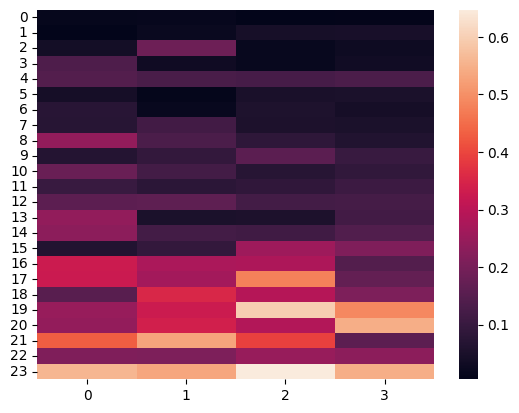

In [65]:
sns.heatmap(1 - avg_cosine_similarities)

<Axes: >

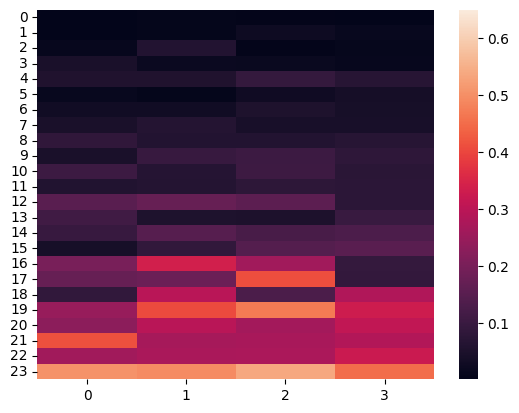

In [103]:
# regular fine-tuning
sns.heatmap(1 - avg_cosine_similarities, vmax=0.65)